In [0]:
%pip install pyspark

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, count, when

In [0]:
# Set the access key for your Azure Blob Storage account
spark.conf.set(
    "fs.azure.account.key.aladdimbigdata.blob.core.windows.net", 
    "accesskey_removed" 
)


### Random Forest Model Training and Prediction

This section implements the machine learning model using Random Forest classification:

1. **Model Initialization**: 
   - We create a Random Forest Classifier with 10 decision trees
   - The model will use our "final_features" column as input and predict the "overall" rating

2. **Model Training**:
   - We fit the Random Forest model on our prepared training data
   - The model learns patterns between our engineered features and review ratings

3. **Prediction Generation**:
   - We apply the trained model to make predictions on all three datasets
   - This creates new dataframes with prediction columns for evaluation
   - Generating predictions on training data allows us to assess potential overfitting

The Random Forest algorithm is well-suited for this task as it handles high-dimensional data effectively and can capture non-linear relationships in the feature space.

In [0]:
from pyspark.sql import SparkSession

# Create or get your SparkSession
spark = SparkSession.builder.appName("RandomForestModel").getOrCreate()

# Load preprocessed Parquet files (contains 'final_features' and 'overall')
rf_base_path = "wasbs://datafiles@aladdimbigdata.blob.core.windows.net/rf_data"

train_df = spark.read.parquet(f"{rf_base_path}/train")
val_df   = spark.read.parquet(f"{rf_base_path}/val")
test_df  = spark.read.parquet(f"{rf_base_path}/test")

# Confirm schema and some rows
train_df.printSchema()
train_df.show(5, truncate=False)


root
 |-- final_features: vector (nullable = true)
 |-- overall: double (nullable = true)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## RandomForest Hyperparameter Tuning and Score Metrics

In [0]:
%pip install catboost
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.r

In [0]:
from pyspark.sql.functions import col

def stratified_sample(df, label_col="overall", fraction=0.1, seed=42):
    """Sample 5% from each class to ensure all classes are represented."""
    sampled_dfs = []
    for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
        class_df = df.filter(col(label_col) == rating)
        sampled = class_df.sample(withReplacement=False, fraction=fraction, seed=seed)
        sampled_dfs.append(sampled)

    # Chain unionByName() one by one
    stratified_df = sampled_dfs[0]
    for df_part in sampled_dfs[1:]:
        stratified_df = stratified_df.unionByName(df_part)
    
    return stratified_df


# Apply stratified 5% sampling to each split
train_df = stratified_sample(train_df, fraction=0.05)
val_df   = stratified_sample(val_df, fraction=0.05)
test_df  = stratified_sample(test_df, fraction=0.05)

# Confirm sample sizes and class presence
print(f"Train Sample Rows: {train_df.count()}")
print(f"Val Sample Rows: {val_df.count()}")
print(f"Test Sample Rows: {test_df.count()}")

train_df.groupBy("overall").count().orderBy("overall").show()
val_df.groupBy("overall").count().orderBy("overall").show()
test_df.groupBy("overall").count().orderBy("overall").show()


Train Sample Rows: 131088
Val Sample Rows: 1633
Test Sample Rows: 1622
+-------+-----+
|overall|count|
+-------+-----+
|    1.0|26196|
|    2.0|26223|
|    3.0|26308|
|    4.0|26248|
|    5.0|26113|
+-------+-----+

+-------+-----+
|overall|count|
+-------+-----+
|    1.0|  240|
|    2.0|  266|
|    3.0|  296|
|    4.0|  379|
|    5.0|  452|
+-------+-----+

+-------+-----+
|overall|count|
+-------+-----+
|    1.0|  236|
|    2.0|  259|
|    3.0|  338|
|    4.0|  397|
|    5.0|  392|
+-------+-----+



In [0]:
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Define evaluator(s) using Spark's MulticlassClassificationEvaluator
evaluator_acc = MulticlassClassificationEvaluator(labelCol="overall", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="overall", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="overall", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="overall", metricName="weightedRecall")

# ======================================================
# Random Forest Hyperparameter Tuning on Full Dataset
# ======================================================
rf = RandomForestClassifier(featuresCol="final_features", labelCol="overall")
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [40, 60])
                .addGrid(rf.maxDepth, [5, 10])
                .build())
cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_acc,
    numFolds=3,
    parallelism=4
)

In [0]:
# Fit the cross-validator
cv_rfModel = cv_rf.fit(train_df)

# Get the best model
best_rfModel = cv_rfModel.bestModel

# 🔹 Save the best model to Azure Blob Storage
best_rfModel.save("wasbs://datafiles@aladdimbigdata.blob.core.windows.net/rf_model/best_rf_model")


# 🔹 Print best hyperparameters
print("✅ Best Random Forest Hyperparameters:")
print(f"  • numTrees  = {best_rfModel.getNumTrees}")
print(f"  • maxDepth  = {best_rfModel.getOrDefault('maxDepth')}")
print(f"  • featureSubsetStrategy = {best_rfModel.getOrDefault('featureSubsetStrategy')}")


✅ Best Random Forest Hyperparameters:
  • numTrees  = 60
  • maxDepth  = 10
  • featureSubsetStrategy = auto


In [0]:


# ✅ Evaluate best Random Forest model on test_df
rf_test_predictions = best_rfModel.transform(test_df)

# Accuracy, F1, Precision, Recall
acc_rf = evaluator_acc.evaluate(rf_test_predictions)
f1_rf = evaluator_f1.evaluate(rf_test_predictions)
prec_rf = evaluator_precision.evaluate(rf_test_predictions)
recall_rf = evaluator_recall.evaluate(rf_test_predictions)

print(f"✅ Random Forest Test Accuracy:  {acc_rf:.4f}")
print(f"✅ Random Forest Test F1 Score:  {f1_rf:.4f}")
print(f"✅ Random Forest Test Precision: {prec_rf:.4f}")
print(f"✅ Random Forest Test Recall:    {recall_rf:.4f}")

# ✅ Compute ROC AUC for Random Forest (limit to 10,000 rows)
rf_test_pd = rf_test_predictions.select("overall", "probability").limit(10000).toPandas()
rf_test_pd['probability'] = rf_test_pd['probability'].apply(lambda x: x.toArray().tolist())

y_true_rf = rf_test_pd['overall'].values
y_score_rf = np.stack(rf_test_pd['probability'].values)

# Trim off the first column (for class 0.0)
if y_score_rf.shape[1] == 6:
    print("⚠️ Detected class 0.0 in model output, trimming it for evaluation.")
    y_score_rf = y_score_rf[:, 1:]


# Binarize true labels
from sklearn.preprocessing import label_binarize
classes = [1.0, 2.0, 3.0, 4.0, 5.0]
y_true_bin = label_binarize(y_true_rf, classes=classes)

# Pad y_score_rf if any class is missing
if y_score_rf.shape[1] < len(classes):
    y_score_rf = np.pad(y_score_rf, ((0, 0), (0, len(classes) - y_score_rf.shape[1])), mode='constant')


from sklearn.preprocessing import label_binarize

# Get unique labels from your prediction sample
unique_classes = sorted(np.unique(y_true_rf))

# Binarize using only the classes actually present in this sample
y_true_bin = label_binarize(y_true_rf, classes=unique_classes)

# Ensure y_score_rf shape matches
if y_score_rf.shape[1] != len(unique_classes):
    raise ValueError(f"Mismatch: y_score_rf has shape {y_score_rf.shape}, but found {len(unique_classes)} classes.")


from sklearn.metrics import roc_auc_score
roc_auc_rf = roc_auc_score(y_true_bin, y_score_rf, multi_class='ovr', average='macro')
print(f"✅ Random Forest Test ROC AUC:   {roc_auc_rf:.4f}")


✅ Random Forest Test Accuracy:  0.3705
✅ Random Forest Test F1 Score:  0.3556
✅ Random Forest Test Precision: 0.3714
✅ Random Forest Test Recall:    0.3705
⚠️ Detected class 0.0 in model output, trimming it for evaluation.
✅ Random Forest Test ROC AUC:   0.7038


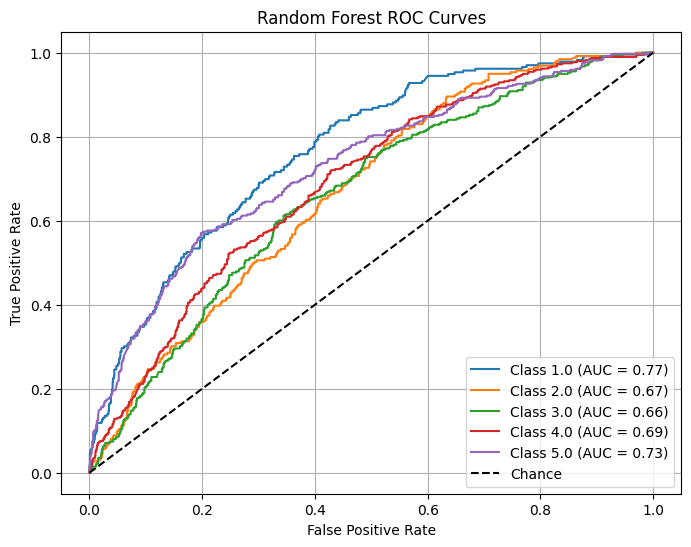

In [0]:
# ✅ Function to plot multiclass ROC curves
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_multiclass_roc(y_true, y_score, model_name="Model"):
    from sklearn.preprocessing import label_binarize
    classes = sorted(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc_dict = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc_dict[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# ✅ Plot ROC for Random Forest
plot_multiclass_roc(y_true_rf, y_score_rf, model_name="Random Forest")


In [0]:
spark.version


'3.4.1'

In [0]:
%pip install catboost

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


## Logistic Regression Hyperparameter Tuning and Score Metrics

In [0]:




from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.ml.feature import Tokenizer, Word2Vec, StringIndexer, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# -----------------------------------------------------------
# 1) Spark Session & Data Loading
# -----------------------------------------------------------
spark = SparkSession.builder.appName("W2V_MLPC_Pipeline").getOrCreate()

cb_base_path = "wasbs://datafiles@aladdimbigdata.blob.core.windows.net/catboost_data"

train_df = spark.read.parquet(f"{cb_base_path}/train")
val_df   = spark.read.parquet(f"{cb_base_path}/val")
test_df  = spark.read.parquet(f"{cb_base_path}/test")

train_df.printSchema()



root
 |-- reviewText: string (nullable = true)
 |-- review_length_normalized: double (nullable = true)
 |-- category: string (nullable = true)
 |-- overall: double (nullable = true)



In [0]:
from pyspark.sql.functions import col

def stratified_sample(df, label_col="overall", fraction=0.1, seed=42):
    """Sample 5% from each class to ensure all classes are represented."""
    sampled_dfs = []
    for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
        class_df = df.filter(col(label_col) == rating)
        sampled = class_df.sample(withReplacement=False, fraction=fraction, seed=seed)
        sampled_dfs.append(sampled)

    # Chain unionByName() one by one
    stratified_df = sampled_dfs[0]
    for df_part in sampled_dfs[1:]:
        stratified_df = stratified_df.unionByName(df_part)
    
    return stratified_df


# Apply stratified 5% sampling to each split
train_df = stratified_sample(train_df, fraction=0.05)
val_df   = stratified_sample(val_df, fraction=0.05)
test_df  = stratified_sample(test_df, fraction=0.05)

# Confirm sample sizes and class presence
print(f"Train Sample Rows: {train_df.count()}")
print(f"Val Sample Rows: {val_df.count()}")
print(f"Test Sample Rows: {test_df.count()}")



Train Sample Rows: 131532
Val Sample Rows: 1585
Test Sample Rows: 1572


In [0]:


# We'll combine them here for cross-validation, just for demonstration:
train_val_df = train_df.unionByName(val_df)

In [0]:
train_df.groupBy("overall").count().show()
test_df.groupBy("overall").count().show()
train_val_df.groupBy("overall").count().show()

+-------+-----+
|overall|count|
+-------+-----+
|    1.0|26214|
|    2.0|26406|
|    3.0|26311|
|    4.0|26447|
|    5.0|26154|
+-------+-----+

+-------+-----+
|overall|count|
+-------+-----+
|    1.0|  236|
|    2.0|  251|
|    3.0|  296|
|    4.0|  397|
|    5.0|  392|
+-------+-----+

+-------+-----+
|overall|count|
+-------+-----+
|    1.0|26470|
|    2.0|26665|
|    3.0|26607|
|    4.0|26826|
|    5.0|26549|
+-------+-----+



In [0]:


from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.ml.feature import (
    Tokenizer, Word2Vec, StringIndexer, IndexToString, VectorAssembler
)
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc


from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="overall",
    outputCol="label"
)


from pyspark.ml.feature import Tokenizer, Word2Vec, VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
w2v = Word2Vec(inputCol="words", outputCol="text_w2v", vectorSize=100, minCount=5)
cat_indexer = StringIndexer(inputCol="category", outputCol="cat_idx")

assembler = VectorAssembler(
    inputCols=["text_w2v", "cat_idx", "review_length_normalized"],
    outputCol="features"
)


lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",    # important: after StringIndexer
    maxIter=100,
    regParam=0.0,
    elasticNetParam=0.0
)


pipeline = Pipeline(stages=[
    label_indexer,
    tokenizer,
    w2v,
    cat_indexer,
    assembler,
    lr
])


model = pipeline.fit(train_df)
predictions = model.transform(test_df)


from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")

acc = evaluator_acc.evaluate(predictions)
f1  = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")


Accuracy: 0.4440 | F1 Score: 0.4430


In [0]:




from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.ml.feature import Tokenizer, Word2Vec, StringIndexer, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# -----------------------------------------------------------
# 1) Spark Session & Data Loading
# -----------------------------------------------------------
spark = SparkSession.builder.appName("LogReg_SeparateVal").getOrCreate()

cb_base_path = "wasbs://datafiles@aladdimbigdata.blob.core.windows.net/catboost_data"

train_df = spark.read.parquet(f"{cb_base_path}/train")
val_df   = spark.read.parquet(f"{cb_base_path}/val")
test_df  = spark.read.parquet(f"{cb_base_path}/test")

train_df.printSchema()

root
 |-- reviewText: string (nullable = true)
 |-- review_length_normalized: double (nullable = true)
 |-- category: string (nullable = true)
 |-- overall: double (nullable = true)



In [0]:
from pyspark.sql.functions import col

def stratified_sample(df, label_col="overall", fraction=0.1, seed=42):
    """Sample 5% from each class to ensure all classes are represented."""
    sampled_dfs = []
    for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
        class_df = df.filter(col(label_col) == rating)
        sampled = class_df.sample(withReplacement=False, fraction=fraction, seed=seed)
        sampled_dfs.append(sampled)

    # Chain unionByName() one by one
    stratified_df = sampled_dfs[0]
    for df_part in sampled_dfs[1:]:
        stratified_df = stratified_df.unionByName(df_part)
    
    return stratified_df


# Apply stratified 5% sampling to each split
train_df = stratified_sample(train_df, fraction=0.05)
val_df   = stratified_sample(val_df, fraction=0.05)
test_df  = stratified_sample(test_df, fraction=0.05)

# Confirm sample sizes and class presence
print(f"Train Sample Rows: {train_df.count()}")
print(f"Val Sample Rows: {val_df.count()}")
print(f"Test Sample Rows: {test_df.count()}")



Train Sample Rows: 131532
Val Sample Rows: 1585
Test Sample Rows: 1572


In [0]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, Tokenizer, Word2Vec, VectorAssembler, IndexToString
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# -----------------------------------------------------------
# 2) Build Pipeline (minus hyperparams)
# -----------------------------------------------------------

# (A) Index label: overall ∈ {1..5} => label ∈ {0..4}
label_indexer = StringIndexer(
    inputCol="overall",
    outputCol="label",
    handleInvalid="error"
)

# (B) Tokenize text
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")

# (C) Word2Vec
w2v = Word2Vec(
    inputCol="words",
    outputCol="text_w2v",
    # We'll set vectorSize in a paramMap below
    minCount=5
)

# (D) Index category
cat_indexer = StringIndexer(
    inputCol="category",
    outputCol="cat_idx",
    handleInvalid="keep"
)

# (E) Assemble features
assembler = VectorAssembler(
    inputCols=["text_w2v", "cat_idx", "review_length_normalized"],
    outputCol="features"
)

# (F) Logistic Regression
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features"
    # We'll set regParam in a paramMap
)

# (G) Convert predictions [0..4] → [1..5]
pred_converter = IndexToString(
    inputCol="prediction",
    outputCol="predicted_overall"
    # We'll populate labels after fitting label_indexer
)

# (H) Pipeline
pipeline = Pipeline(stages=[
    label_indexer,   # stage 0
    tokenizer,       # stage 1
    w2v,             # stage 2
    cat_indexer,     # stage 3
    assembler,       # stage 4
    lr,              # stage 5
    pred_converter   # stage 6
])

# -----------------------------------------------------------
# 3) Hyperparameter Tuning Using Separate train/val
# -----------------------------------------------------------
eval_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

vec_sizes = [50, 100]
reg_params = [0.0, 0.05]

best_acc = float("-inf")
best_model = None
best_params = None

for vec_size in vec_sizes:
    for reg_param in reg_params:
        # Dictionary of Param objects -> values
        param_map = {
            w2v.getParam("vectorSize"): vec_size,
            lr.getParam("regParam"): reg_param
        }

        # Fit on train with the given paramMap
        model = pipeline.fit(train_df, param_map)

        # Optionally set predicted_overall labels from label_indexer
        label_idx_model = model.stages[0]  # the fitted StringIndexer
        pred_converter_model = model.stages[-1]
        pred_converter_model.setLabels(label_idx_model.labels)

        # Evaluate on val
        val_preds = model.transform(val_df)
        acc_val = eval_acc.evaluate(val_preds)

        print(f"[INFO] vectorSize={vec_size}, regParam={reg_param} => val_acc={acc_val:.4f}")

        if acc_val > best_acc:
            best_acc = acc_val
            best_model = model
            best_params = (vec_size, reg_param)

print(f"\n✅ Best val accuracy={best_acc:.4f} with (vectorSize, regParam)={best_params}")

# -----------------------------------------------------------
# 4) Evaluate Best Model on Test
# -----------------------------------------------------------
test_preds = best_model.transform(test_df)

eval_f1       = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
eval_precision= MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
eval_recall   = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

acc_test = eval_acc.evaluate(test_preds)
f1_test  = eval_f1.evaluate(test_preds)
prec_test= eval_precision.evaluate(test_preds)
rec_test = eval_recall.evaluate(test_preds)

print("\n===============================")
print("Evaluation on Test Set")
print("===============================")
print(f"Accuracy:   {acc_test:.4f}")
print(f"F1 Score:   {f1_test:.4f}")
print(f"Precision:  {prec_test:.4f}")
print(f"Recall:     {rec_test:.4f}")



[INFO] vectorSize=50, regParam=0.0 => val_acc=0.4366
[INFO] vectorSize=50, regParam=0.05 => val_acc=0.4139
[INFO] vectorSize=100, regParam=0.0 => val_acc=0.4442
[INFO] vectorSize=100, regParam=0.05 => val_acc=0.4341

✅ Best val accuracy=0.4442 with (vectorSize, regParam)=(100, 0.0)

Evaluation on Test Set
Accuracy:   0.4440
F1 Score:   0.4430
Precision:  0.4466
Recall:     0.4440



Multiclass ROC AUC (macro) = 0.7606


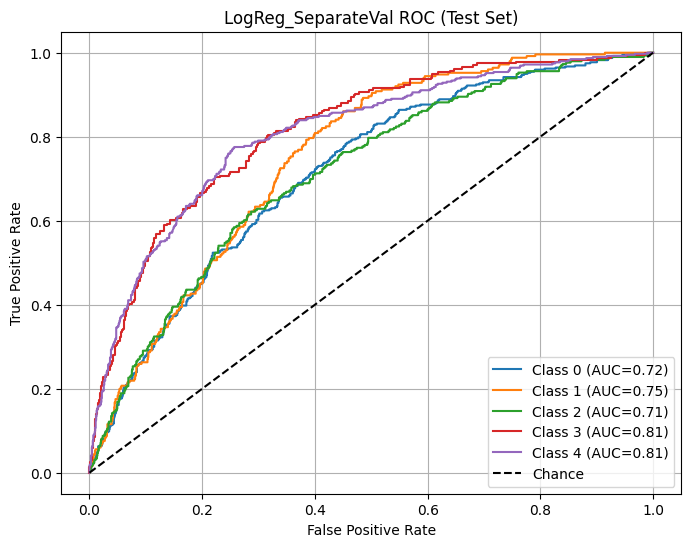

Saving best model to: wasbs://datafiles@aladdimbigdata.blob.core.windows.net/catboost_data/best_logreg_model_separate_val
All done!


In [0]:
# -----------------------------------------------------------
# 5) Multiclass ROC / AUC
# -----------------------------------------------------------
test_pd = (
    test_preds
    .select("label", "probability", "predicted_overall")
    .limit(10000)
    .toPandas()
)

test_pd["probability"] = test_pd["probability"].apply(lambda x: x.toArray().tolist())
y_true = test_pd["label"].values.astype(int)
y_score = np.stack(test_pd["probability"].values)

n_classes = len(np.unique(y_true))  # typically 5
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

if y_score.shape[1] < n_classes:
    y_score = np.pad(y_score, ((0,0), (0, n_classes - y_score.shape[1])), mode='constant')

roc_auc = roc_auc_score(y_true_bin, y_score, multi_class='ovr', average='macro')
print(f"\nMulticlass ROC AUC (macro) = {roc_auc:.4f}")

def plot_multiclass_roc(y_true_arr, y_score_arr, model_name="LogReg"):
    ncls = len(np.unique(y_true_arr))
    y_bin = label_binarize(y_true_arr, classes=list(range(ncls)))

    fpr, tpr, roc_auc_dict = {}, {}, {}
    for i in range(ncls):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score_arr[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(ncls):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc_dict[i]:.2f})")

    plt.plot([0,1],[0,1], 'k--', label="Chance")
    plt.title(f"{model_name} ROC (Test Set)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_multiclass_roc(y_true, y_score, model_name="LogReg_SeparateVal")

# -----------------------------------------------------------
# 6) Save Best Model
# -----------------------------------------------------------
save_path = f"{cb_base_path}/best_logreg_model_separate_val"
print(f"Saving best model to: {save_path}")
best_model.write().overwrite().save(save_path)

print("All done!")
